In [1]:
from sklearnex import patch_sklearn
patch_sklearn()
import pandas as pd
import nltk
import string,re
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (ConfusionMatrixDisplay,classification_report,accuracy_score,
                            precision_score,roc_auc_score)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as pp

pd.set_option('display.max_colwidth', 400)
pd.set_option('display.max_rows', 1000) 

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
df_cleaned = pd.read_csv("../dataset/vax_tweets_sentiment_cleaned.csv")

In [3]:
df_cleaned.head()

,orig_text,sentiment,user_name,date,hashtags,cleaned_text
0,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,neutral,Rachel Roh,2020-12-20,['PfizerBioNTech'],same folks daikon paste could treat cytokine storm
1,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",positive,Albert Fong,2020-12-13,NaN,while world wrong side history year hopefully biggest vaccination effort ev
2,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,neutral,eli🇱🇹🇪🇺👌,2020-12-12,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",russian vaccine created last years
3,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",neutral,Charles Adler,2020-12-12,NaN,facts immutable senator even not ethically sturdy enough acknowledge were born
4,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,neutral,Citizen News Channel,2020-12-12,"['whereareallthesickpeople', 'PfizerBioNTech']",explain again need vaccine


In [4]:
#Split dataset into training and test set

x = df_cleaned['cleaned_text']
y = df_cleaned['sentiment']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

In [5]:
def create_grid_search(ml_algo):
    tfidf = TfidfVectorizer()
  
    param_grid = {'tfidf__ngram_range':[(1,1),(1,2)],
                 'tfidf__max_features':[4000,9000,None]}
        
    pipe = Pipeline(steps=[("tfidf", tfidf), ("nb", ml_algo)])
    
    search = GridSearchCV(pipe, param_grid, cv=10, scoring="balanced_accuracy", n_jobs=-1)
    return search

In [6]:
#Run gridsearchcv to find best parameter for tfidf and machine learning algorithm

nb = MultinomialNB()
model_grid_search = create_grid_search(nb)

model_grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tfidf__max_features': [4000, 9000, None],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='balanced_accuracy')

In [7]:
print(model_grid_search.best_estimator_)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=4000, ngram_range=(1, 2))),
                ('nb', MultinomialNB())])


In [8]:
tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=4000)
tfidf.fit(X_train)

X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [9]:
#Undersampling functions

def undersampling(ml_algo):
    result = pd.DataFrame()
    no_of_sample = pd.DataFrame()
    
    for sampler,index_text in [(TomekLinks(sampling_strategy = ['neutral'], n_jobs=-1),'NB+TomekLinks')]:
                   
        us_xtrain_tfidf, us_train_y = sampler.fit_resample(X_train_tfidf, y_train)
        ml_algo.fit(us_xtrain_tfidf,us_train_y)
        
        result = pd.concat([result,evaluate(ml_algo,index_text)])
    return result 

In [10]:
#Oversampling functions

def oversampling(ml_algo):
    result = pd.DataFrame()
    for sampler,index_text in [(SMOTE(sampling_strategy={'positive': 6000,'negative': 6000},random_state=777,
                                     n_jobs=-1), 'NB+SMOTE')]:
        
        os_xtrain_tfidf, os_train_y = sampler.fit_resample(X_train_tfidf, y_train)
        ml_algo.fit(os_xtrain_tfidf,os_train_y)

        result = pd.concat([result,evaluate(ml_algo,index_text)])
    return result 

In [11]:
#Oversampling + Undersampling functions

def over_under_sampling(ml_algo):
    result = pd.DataFrame()
    
      
    for sampler_over,index_text_over in [(SMOTE(sampling_strategy={'positive': 6000,'negative': 6000},
                                               random_state=777, n_jobs=-1), 'SMOTE')]:
        for sampler_under,index_text_under in [(TomekLinks(sampling_strategy = ['neutral'], n_jobs=-1),
                                                'TomekLinks')]:
            
            over = sampler_over
            under = sampler_under
    
            steps = [('o', over), ('u', under), ('m', ml_algo)]
            pipeline = pp(steps=steps)
    
            pipeline.fit(X_train_tfidf, y_train)
            result = pd.concat([result,evaluate(ml_algo,"NB+"+index_text_over+"+"+index_text_under)])
    return result   

In [12]:
#Classification performance evaluation

def evaluate(model,index_text):
    predict = model.predict(X_test_tfidf)
    
    class_report = classification_report(y_test,predict,output_dict=True)
    accuracy = class_report['accuracy']
    precision = class_report['weighted avg']['precision']
    recall = class_report['weighted avg']['recall']
    f1 = class_report['weighted avg']['f1-score']
    
    predict_proba = model.predict_proba(X_test_tfidf)
    roc_auc = roc_auc_score(y_test, predict_proba, average="weighted", multi_class="ovr")
    
    print("\n"+index_text+"\n")
    print(classification_report(y_test,predict))
    
    print("\nROC AUC: " + str(roc_auc))
    
    print("\nConfusion Matrix:\n")
    ConfusionMatrixDisplay.from_predictions(y_test, predict)
    plt.show()
    
    return pd.DataFrame(
        data={"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1, 
              "ROC AUC": roc_auc},
        index=[index_text]
    )


Naïve Bayes

              precision    recall  f1-score   support

    negative       0.75      0.35      0.48       839
     neutral       0.75      0.95      0.84      3334
    positive       0.85      0.53      0.65      1170

    accuracy                           0.76      5343
   macro avg       0.78      0.61      0.66      5343
weighted avg       0.77      0.76      0.74      5343


ROC AUC: 0.8486121950000263

Confusion Matrix:



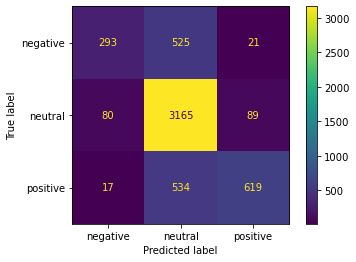

In [13]:
#Naïve Bayes using original dateset

nb = MultinomialNB()
nb.fit(X_train_tfidf,y_train)

eval_result = evaluate(nb,"Naïve Bayes")


NB+TomekLinks

              precision    recall  f1-score   support

    negative       0.74      0.37      0.49       839
     neutral       0.75      0.94      0.84      3334
    positive       0.83      0.54      0.65      1170

    accuracy                           0.76      5343
   macro avg       0.77      0.62      0.66      5343
weighted avg       0.77      0.76      0.74      5343


ROC AUC: 0.8484112794832602

Confusion Matrix:



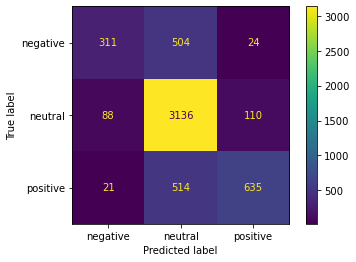

In [14]:
#Naïve Bayes using undersampled dataset

nb = MultinomialNB()
eval_result = pd.concat([eval_result,undersampling(nb)])


NB+SMOTE

              precision    recall  f1-score   support

    negative       0.62      0.52      0.56       839
     neutral       0.79      0.89      0.84      3334
    positive       0.81      0.60      0.69      1170

    accuracy                           0.77      5343
   macro avg       0.74      0.67      0.70      5343
weighted avg       0.77      0.77      0.76      5343


ROC AUC: 0.8467624671860117

Confusion Matrix:



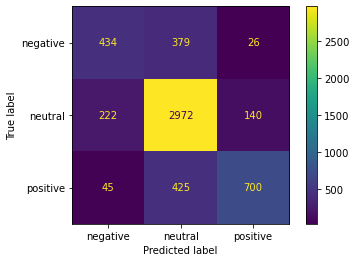

In [15]:
#Naïve Bayes using oversampled dataset

eval_result = pd.concat([eval_result,oversampling(nb)])


NB+SMOTE+TomekLinks

              precision    recall  f1-score   support

    negative       0.61      0.52      0.56       839
     neutral       0.79      0.89      0.84      3334
    positive       0.80      0.61      0.69      1170

    accuracy                           0.77      5343
   macro avg       0.74      0.67      0.70      5343
weighted avg       0.76      0.77      0.76      5343


ROC AUC: 0.846677318595079

Confusion Matrix:



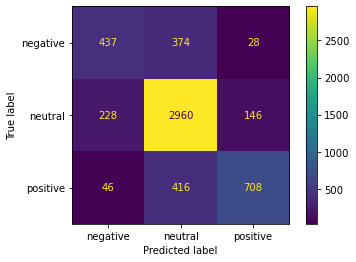

In [16]:
#Naïve Bayes using oversampled & undersampled dataset

eval_result = pd.concat([eval_result,over_under_sampling(nb)])

In [17]:
#Naïve Bayes performance comparison between original and resampled dataset

eval_result

,Accuracy,Precision,Recall,F1-Score,ROC AUC
Naïve Bayes,0.763054,0.771461,0.763054,0.740239,0.848612
NB+TomekLinks,0.763990,0.768171,0.763990,0.743666,0.848411
NB+SMOTE,0.768482,0.765352,0.768482,0.760743,0.846762
NB+SMOTE+TomekLinks,0.768295,0.764831,0.768295,0.761114,0.846677


In [18]:
#Save the best model using joblib

tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=4000)

pipe_model = Pipeline(steps=[("tfidf", tfidf), ("nb", nb)])

pipe_model.fit(X_train,y_train)

joblib.dump(pipe_model, './model/nb_model.joblib')

['./model/nb_model.joblib']